In [1]:
import sys
import os
import numpy as np
from scipy.io import loadmat

In [2]:
def load_normalized_mat(mat_path):
    
    mat = loadmat(mat_path)
    gaze_vec = mat['data'][0][0][0][0][0][0]
    eye_img = mat['data'][0][0][0][0][0][1]
    
    return eye_img, gaze_vec

In [71]:
mat_path_train = '../data/MPIIGaze/Data/Normalized/p00/day01.mat'
mat_path_val = '../data/MPIIGaze/Data/Normalized/p00/day02.mat'

eye_img_tr, gaze_vec_tr = load_normalized_mat(mat_path_train)
eye_img_val, gaze_vec_val = load_normalized_mat(mat_path_val)

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib notebook

<IPython.core.display.Javascript object>


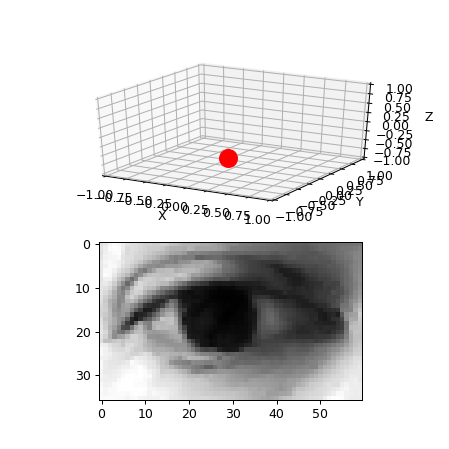

In [72]:
gid = 21

zero = np.zeros([1, 3])
gaze = gaze_vec_tr[gid, :].reshape([1, 3])

gaze_dir = gaze #np.vstack([zero, gaze])

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(211, projection='3d')

ax.scatter(gaze_dir[:,0] , gaze_dir[:, 1], gaze_dir[:, 2], color='red', s=200)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax2 = fig.add_subplot(212)

ax2.imshow(eye_img_tr[gid], cmap='gray')

fig.show()

In [18]:
def show_gaze_dir(gaze_vec, ax=None):

    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
    
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    mesh_size = 50j
    phi, theta = np.mgrid[0:2*pi:mesh_size, 0:pi:mesh_size]
    
    x = r * sin(theta) * cos(phi)
    y = r * sin(theta) * sin(phi)
    z = r * cos(theta)
    
    ax.plot_surface(x, y, z,  rstride=1, cstride=1)

    ax.scatter(gaze_vec[:,0] , gaze_vec[:, 1], gaze_vec[:, 2], s=200, color='red', zorder=1)
    
    return ax

def show_eye_gaze(eye_img, gaze_vec, axes=None):
    
    if axes is None:
        fig, axes = plt.subplots(2, figsize=(10, 10))
    
    axes[0].imshow(eye_img)
        
    return fig

In [17]:
import math as m

def cart_to_spherical(xyz):
    r_phi_theta = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    r_phi_theta[:,0] = np.sqrt(xy + xyz[:,2]**2)
    r_phi_theta[:,1] = np.arctan2( xyz[:,1], xyz[:,0]) # for elevation angle defined from XY-plane up
    r_phi_theta[:,2] = np.arccos(xyz[:, 2]) #theta = arccos(z/r)
    return r_phi_theta

def spherical_to_cart(phi, theta):
    
    return

def get_mesh_pos(target_phi, target_theta, phi_mesh, theta_mesh):
    phi_pos = np.where(phi_mesh[:, 0]<=target_phi)[0][-1]
    theta_pos = np.where(theta_mesh[0, :]<=target_theta)[0][-1]
    return phi_pos, theta_pos

<IPython.core.display.Javascript object>


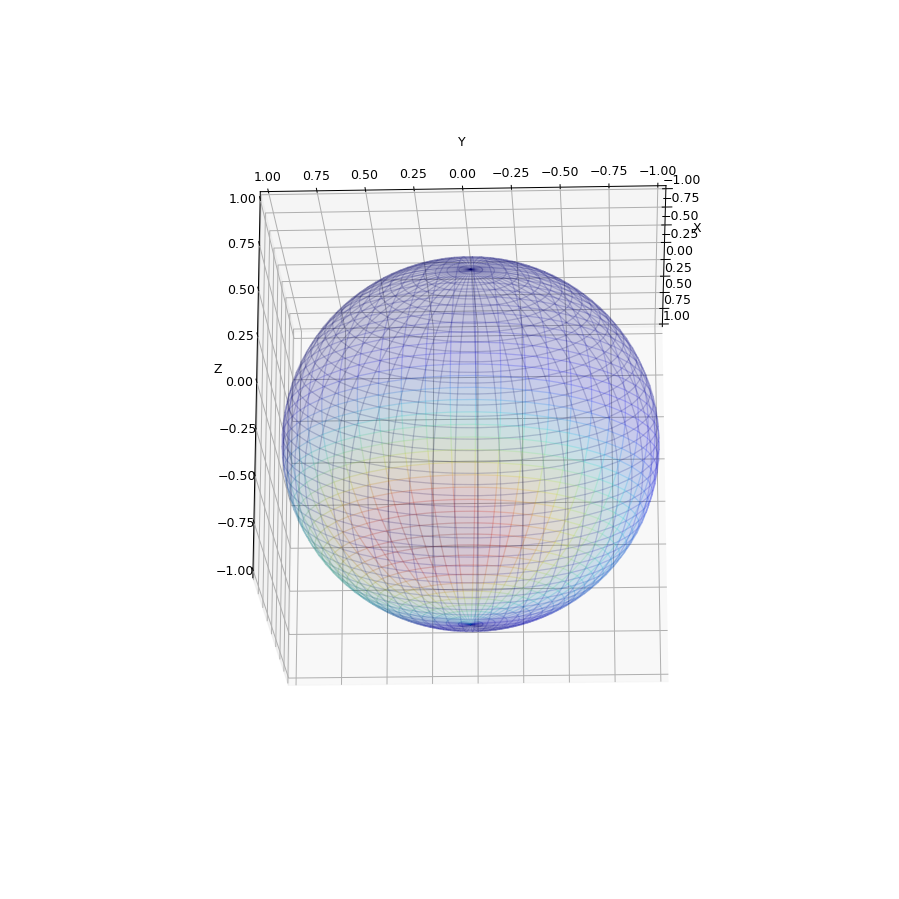

In [65]:
import matplotlib.pyplot as plt
%matplotlib notebook 
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import special
from scipy.stats import vonmises, norm
from von_mises_fisher import vmf_log_pdf

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
mesh_size = 50j
phi_mesh, theta_mesh = np.mgrid[0:2*pi:mesh_size, 0:pi:mesh_size]

x = r * sin(theta_mesh) * cos(phi_mesh)
y = r * sin(theta_mesh) * sin(phi_mesh)
z = r * cos(theta_mesh)
hmap = np.zeros(x.shape)

r_phi_theta = cart_to_spherical(gaze)
target_phi = r_phi_theta[:, 1] 
target_theta = r_phi_theta[:, 2] 

phi_pos, theta_pos = get_mesh_pos(target_phi, target_theta, phi_mesh, theta_mesh)

theta_probs = vonmises(loc=2.35, kappa=5.0).pdf(theta_mesh)
phi_probs =  vonmises(loc=2.84, kappa=1.0).pdf(phi_mesh)
hmap = theta_probs*phi_probs

#hmap[:, 0:10] = 1
#hmap[-10:, -10:] = 1
#hmap[phi_pos, :] = 1
#hmap[39, 20] = 1

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

#ax.scatter(1.1 , 0, 0, s=200, color='red', zorder=0)

norm=colors.Normalize(vmin = np.min(hmap), vmax = np.max(hmap), clip = False)

ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.jet(norm(hmap)), alpha=0.1)
#ax.scatter(gaze[:,0] , gaze[:, 1], gaze[:, 2], color='red')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [82]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import special
from scipy.stats import vonmises, norm

# Create a sphere
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
mesh_size = 100j
phi, theta = np.mgrid[0:2*pi:mesh_size, 0:2*pi:mesh_size/2]

x = r * sin(theta) * cos(phi)
y = r * sin(theta) * sin(phi)
z = r * cos(theta)

phi_vals = np.mgrid[0:2*pi:mesh_size]
theta_vals = np.mgrid[0:pi:mesh_size/2]

_, theta_gt, phi_gt = cart2sph(gaze_vec_tr[0,0], gaze_vec_tr[0,1], gaze_vec_tr[0,2])
phi_pdf = vonmises.pdf(phi_vals, loc=pi, kappa=1.0).reshape([1, -1])
theta_pdf = vonmises.pdf(theta_vals, loc=pi/4, kappa=1.0).reshape([1, -1])

#norm = colors.Normalize()

colorfunction = np.zeros([100, 50]) #phi_pdf.T.dot(theta_pdf)

norm=colors.Normalize(vmin = np.min(colorfunction), vmax = np.max(colorfunction), clip = False)

#print(colorfunction)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x, y, z)
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.jet(norm(colorfunction)))

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

NameError: name 'cart2sph' is not defined

In [75]:
from models import vgg
from utils.angles import rad2bit, bit2deg


image_height, image_width  = eye_img_tr.shape[1:3]

vggbit_cosine_model_phi = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=1,
                                predict_kappa=False,
                                loss_type='cosine')

vggbit_cosine_model_theta = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=1,
                                predict_kappa=False,
                                loss_type='cosine')

eye_img_tr_exp = np.expand_dims(eye_img_tr, axis=-1)
eye_img_val_exp = np.expand_dims(eye_img_val, axis=-1)


using cosine loss..
using cosine loss..


In [99]:
phi_theta_tr = cart_to_spherical(gaze_vec_tr)
phi_bit_tr = rad2bit(phi_theta_tr[:, 1])
theta_bit_tr = rad2bit(phi_theta_tr[:, 2])
phi_deg_tr = np.rad2deg(phi_theta_tr[:, 1])
theta_deg_tr = np.rad2deg(phi_theta_tr[:, 2])
phi_theta_val = cart_to_spherical(gaze_vec_val)
phi_bit_val = rad2bit(phi_theta_val[:, 1])
theta_bit_val = rad2bit(phi_theta_val[:, 2])
phi_deg_val = np.rad2deg(phi_theta_val[:, 1])
theta_deg_val = np.rad2deg(phi_theta_val[:, 2])

In [86]:
vggbit_cosine_model_theta.fit(train_data=[eye_img_tr_exp, theta_bit_tr], val_data=[eye_img_val_exp, theta_bit_val], n_epochs=10, batch_size=32)

Train on 995 samples, validate on 858 samples
Epoch 1/10
995/995 [==============================] - 27s - loss: 0.0453 - val_loss: 0.0036
Epoch 2/10
995/995 [==============================] - 23s - loss: 0.0040 - val_loss: 0.0023
Epoch 3/10
995/995 [==============================] - 21s - loss: 0.0030 - val_loss: 0.0019
Epoch 4/10
995/995 [==============================] - 23s - loss: 0.0027 - val_loss: 0.0017
Epoch 5/10
995/995 [==============================] - 21s - loss: 0.0022 - val_loss: 0.0016
Epoch 6/10
995/995 [==============================] - 21s - loss: 0.0019 - val_loss: 0.0013
Epoch 7/10
995/995 [==============================] - 21s - loss: 0.0019 - val_loss: 0.0012
Epoch 8/10
995/995 [==============================] - 22s - loss: 0.0016 - val_loss: 0.0012
Epoch 9/10
995/995 [==============================] - 23s - loss: 0.0013 - val_loss: 0.0011
Epoch 10/10
995/995 [==============================] - 20s - loss: 0.0013 - val_loss: 0.0011


In [85]:
vggbit_cosine_model_phi.fit(train_data=[eye_img_tr_exp, phi_bit_tr], val_data=[eye_img_val_exp, phi_bit_val], n_epochs=10, batch_size=32)

Train on 995 samples, validate on 858 samples
Epoch 1/10
995/995 [==============================] - 24s - loss: 0.2141 - val_loss: 0.5144
Epoch 2/10
995/995 [==============================] - 21s - loss: 0.1056 - val_loss: 0.3177
Epoch 3/10
995/995 [==============================] - 20s - loss: 0.0746 - val_loss: 0.1508
Epoch 4/10
995/995 [==============================] - 26s - loss: 0.0598 - val_loss: 0.1156
Epoch 5/10
995/995 [==============================] - 24s - loss: 0.0673 - val_loss: 0.1088
Epoch 6/10
995/995 [==============================] - 20s - loss: 0.0508 - val_loss: 0.1170
Epoch 7/10
995/995 [==============================] - 21s - loss: 0.0545 - val_loss: 0.1114
Epoch 8/10
995/995 [==============================] - 19s - loss: 0.0437 - val_loss: 0.1299
Epoch 9/10
995/995 [==============================] - 20s - loss: 0.0389 - val_loss: 0.0970
Epoch 10/10
995/995 [==============================] - 20s - loss: 0.0330 - val_loss: 0.0679


In [89]:
theta_preds_tr = vggbit_cosine_model_theta.model.predict(eye_img_tr_exp)
phi_preds_tr = vggbit_cosine_model_phi.model.predict(eye_img_tr_exp)

In [105]:
theta_preds_val = vggbit_cosine_model_theta.model.predict(eye_img_val_exp)
phi_preds_val = vggbit_cosine_model_phi.model.predict(eye_img_val_exp)

In [97]:
theta_preds_deg = bit2deg(theta_preds)
phi_preds_deg = bit2deg(phi_preds)

In [104]:
np.mean(np.abs(phi_deg_tr - phi_preds_deg))

19.061137966653195

In [103]:
np.mean(np.abs(theta_deg_tr - theta_preds_deg))

1.6546716297144897